<a href="https://colab.research.google.com/github/jlaraUOC/PEC-2-VISUALIZACION-DE-DATOS/blob/main/PEC2_jlarachu_Enunciado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div style="width: 100%; clear: both;">
<div style="float: left; width: 20%;">
<img src="https://www.uoc.edu/portal/_resources/common/imatges/sala_de_premsa/noticies/2016/202-nova-marca-uoc.jpg_170798054.jpg", align="left">
</div>
<div style="float: right; width: 80%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.855 · Modelos avanzados de minería de datos · PEC2</p>
<p style="margin: 0; text-align:right;">2023-1 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 2: Métodos no supervisados

**Importante: la entrega debe contener el notebook (.ipynb) y su HTML tras la completa ejecución secuencial (.html) donde se pueda ver el código y los resultados. Para exportar el notebook a HTML puedes hacerlo desde el menú File → Download as → HTML.**

A lo largo de esta práctica veremos como aplicar distintas técnicas no supervisadas
así como algunas de sus aplicaciones reales:

 - **[Clustering con distintas estrategias](#ej1)**: k-means y regla del codo, basadas en densidad y jerárquicas.
 - **[Ejemplo práctico con aperturas de ajedrez](#ej2)**: reducción de dimensionalidad, clustering y análisis.

<div class="alert alert-block alert-info">
<strong>Nombre y apellidos: JUAN LARA CHUPS</strong>
</div>

In [ ]:
!pip install umap-learn
!pip install --upgrade hdbscan

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.9/90.9 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.8/55.8 kB 7.6 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.5-py3-none-any.whl size=86831 sha256=6a4320c67c1b4b829cf3a5c24b020f4ef06a2de97c8f38b5ddaea412f887a414
  Stored in directory: /root/.cache/pip/wheels/3a/70/07/428d2b58660a1a3b431db59b806a10da736612ebbc66c1bcc5
Successfully built umap-learn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 33.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached Cython-0.29.36-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_24_x86_64.whl (1.9 MB)
  Created wheel for hdbscan: filename=hdbscan-0.8.33-cp310-cp310-linux_x86_64.whl size=3039170 sha256=8742cb6ab80f06e6fcc4afe2cfb79fccbb266ad6e65fe0d32147e4647d6debb0
  S

---

Para ello vamos a necesitar las siguientes librerías:

In [ ]:
import random

import tqdm
import umap
import numpy as np
import pandas as pd
import sklearn
from sklearn import cluster        # Algoritmos de clustering.
from sklearn import datasets       # Crear datasets.
from sklearn import decomposition  # Algoritmos de reduccion de dimensionalidad.

# Visualizacion.
import matplotlib
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px

%matplotlib inline

<a id="ej1"></a>

## 1. Métodos de *clustering* (4 puntos)

Este ejercicio trata de explorar distintas técnicas de agrupamiento ajustándolas a distintos conjuntos de datos.

El objetivo es doble: entender la influencia de los parámetros en su comportamiento, y conocer sus limitaciones en la búsqueda de estructuras de datos.

### Generación de los conjuntos de datos

In [ ]:
X_blobs, y_blobs = datasets.make_blobs(n_samples=1000, n_features=2, centers=4, cluster_std=1.6, random_state=42)
X_moons, y_moons = datasets.make_moons(n_samples=1000, noise=.07, random_state=42)
X_circles, y_circles = datasets.make_circles(n_samples=1000, factor=.5, noise=.05, random_state=42)

Cada dataset tiene 2 variables: una variable *X* que contiene 2 features (columnas) y tantas filas como muestras. Y una variable *y* que alberga las etiquetas que identifican cada cluster.

A lo largo del ejercicio no se usará la variable *y* (sólo con el objetivo de visualizar). El objetivo es a través de los distintos modelos de *clustering* conseguir encontrar las estructuras descritas por las variables *y*.

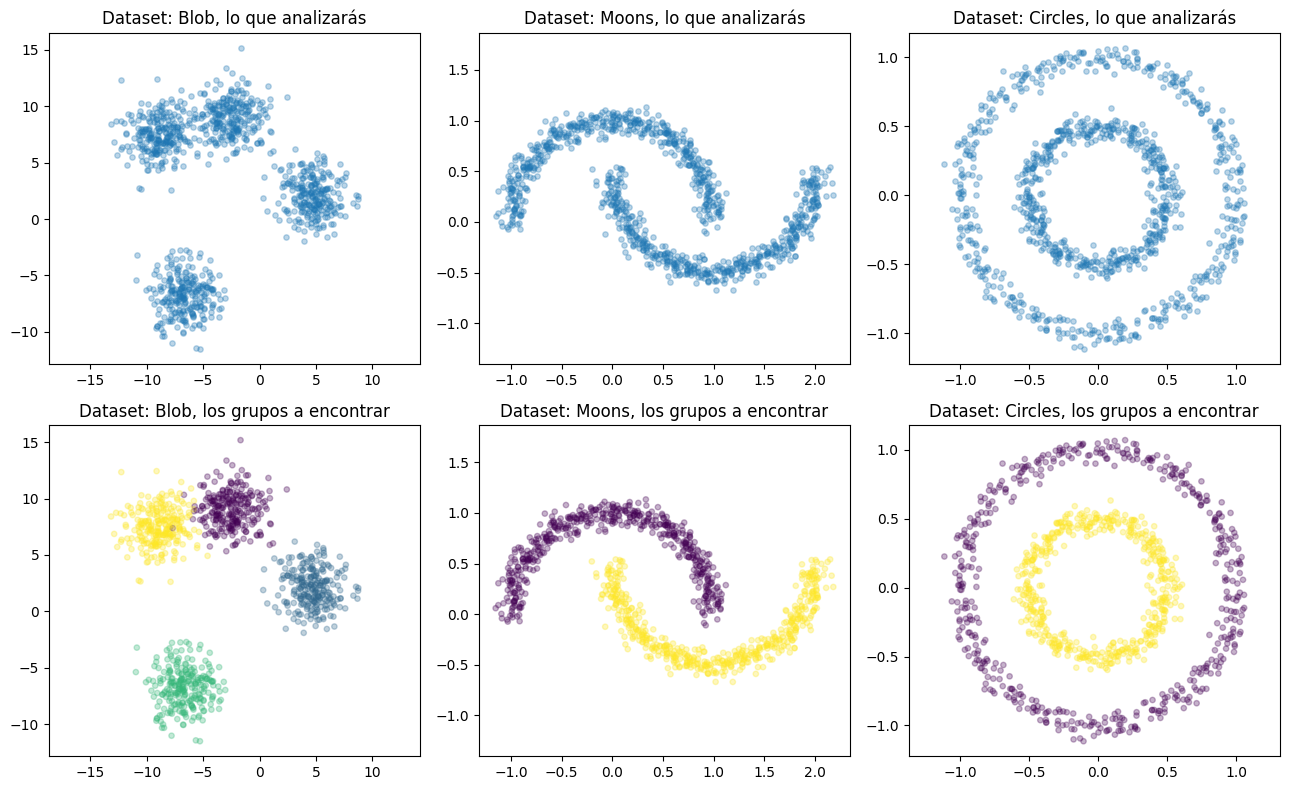

In [ ]:
fig, axis = plt.subplots(2, 3, figsize=(13, 8))
for i, (X, y, ax, name) in enumerate(zip([X_blobs, X_moons, X_circles] * 2,
                                         [None] * 3 + [y_blobs, y_moons, y_circles],
                                         axis.reshape(-1),
                                         ['Blob', 'Moons', 'Circles'] * 2)):
    ax.set_title('Dataset: {}, '.format(name) + ('lo que analizarás' if i < 3 else 'los grupos a encontrar'))
    ax.scatter(X[:,0], X[:,1], s=15, c=y, alpha=.3)
    ax.axis('equal')
plt.tight_layout()

### 1 a. K-means

En este apartado se pide probar el algoritmo *k-means* sobre los tres datasets presentados anteriormente ajustando con los parámetros adecuados y analizar sus resultados.

In [ ]:
X, y = X_blobs, y_blobs

Para estimar el número de clusters a detectar por *k-means*. Una técnica para estimar $k$ es, como se explica en la teoría:
> Los criterios anteriores (minimización de distancias intra grupo o maximización de distancias inter grupo) pueden usarse para establecer un valor adecuado para el parámetro k. Valores k para los que ya no se consiguen mejoras significativas en la homogeneidad interna de los segmentos o la heterogeneidad entre segmentos distintos, deberían descartarse.

Lo que popularmente se conocer como *regla del codo*.

Primero es necesario calcular la suma de los errores cuadráticos ([*SSE*](https://bl.ocks.org/rpgove/0060ff3b656618e9136b)) que consiste en la suma de todos los errores (distancia de cada punto a su centroide asignado) al cuadrado.

$$SSE = \sum_{i=1}^{K} \sum_{x \in C_i} euclidean(x, c_i)^2$$

Donde $K$ es el número de clusters a buscar por *k-means*, $x \in C_i$ son los puntos que pertenecen a i-ésimo cluster, $c_i$ es el centroide del cluster $C_i$ (al que pertenece el punto $x$), y $euclidean$ es la [distancia euclídea](https://en.wikipedia.org/wiki/Euclidean_distance).

Este procedimiento realizado para cada posible valor $k$, resulta en una función monótona decreciente, donde el eje $x$ representa los distintos valores de $k$, y el eje $y$ el $SSE$. Intuitivamente se podrá observar un significativo descenso del error, que indicará el valor idóneo de $k$.

**Se pide realizar la representación gráfica de la regla del codo junto a su interpretación, utilizando la librería ```matplotlib``` y la implementación en scikit-learn de [*k-means*](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html).**

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Blobs.
</div>

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

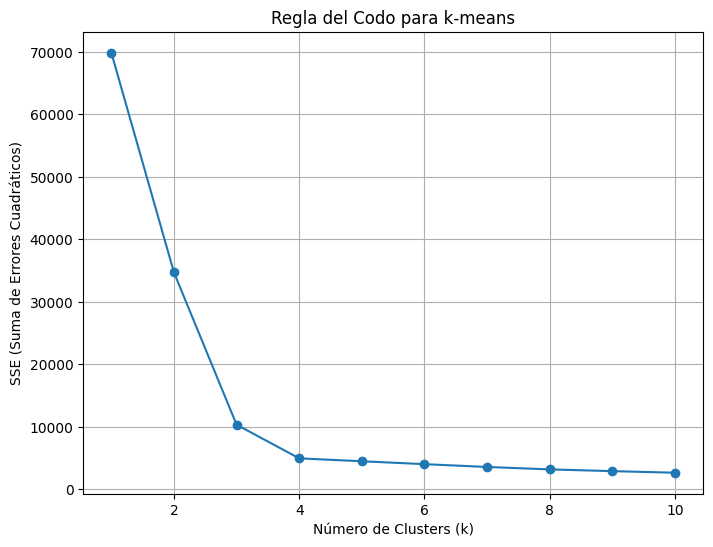

In [ ]:
sse = []
for k in range(1, 11):
    kmeans = cluster.KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# Representar gráficamente la regla del codo
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Regla del Codo para k-means')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('SSE (Suma de Errores Cuadráticos)')
plt.grid(True)
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

En la grafica se puede observar la representacion de la regla de codo para la eleccion de K cluster para este algoritmo. En el podemos sacar la conclusion de que el mejor numero de cluster es 4 (k=4) debidoa que en el se reduce considerablemente el error y, ademas, no se aprecia una reduccion del error importante al aumentar el numero de clusters.

Al realizar el algoritmo k-means, este se centra en minimizar la distancia intra-grupo utilizando la distancia euclidean. Por lo que, para mejor la eleccion de k se podria utilizar otra forma que incluyera la distancia inter-grupo.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Blobs.
</div>

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


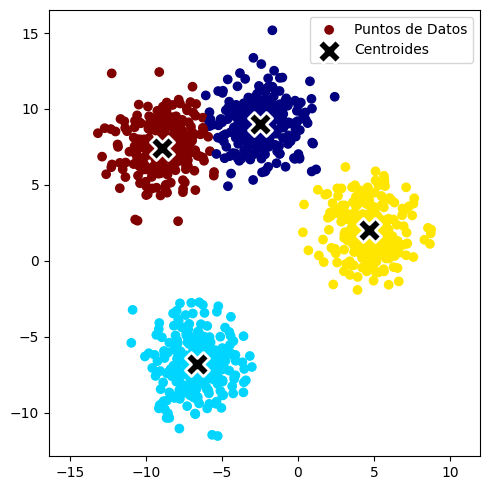

In [ ]:
# Configurar el gráfico
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Configurar y ajustar el modelo K-means
kmeans = cluster.KMeans(n_clusters=4, algorithm='full')
labels = kmeans.fit_predict(X)

# Visualizar los puntos de datos y los centroides
scatter = ax.scatter(X[:, 0], X[:, 1], c=labels, cmap='jet')
centers = ax.scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
    s=300, c='k', marker='X', linewidths=2, edgecolors='w'
)

# Añadir leyenda
ax.legend([scatter, centers], ['Puntos de Datos', 'Centroides'])

# Configurar el aspecto del gráfico
ax.axis('equal')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.
</div>

En el metodo estandar utilizado de k means se asume la distancia euclidea. Este metodo elige los centroides aleatoriamente y se van ajustando al que minimice el error. Como se toma de referencia el centroide de los cluster, la distancia euclidea asume que los cluster van a tener una forma "circular" por lo que en este caso ha separado bastante bien los datos.     

Cabe destacar que en este caso ha sido correcto utilizar esta distancia, pero en la practica podemos encontrarnos con conjuntos de datos para clasifica donde no funcione correctamente o el resultado no sea eficiente de este algoritmo utilizado

In [ ]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Moons.
</div>

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

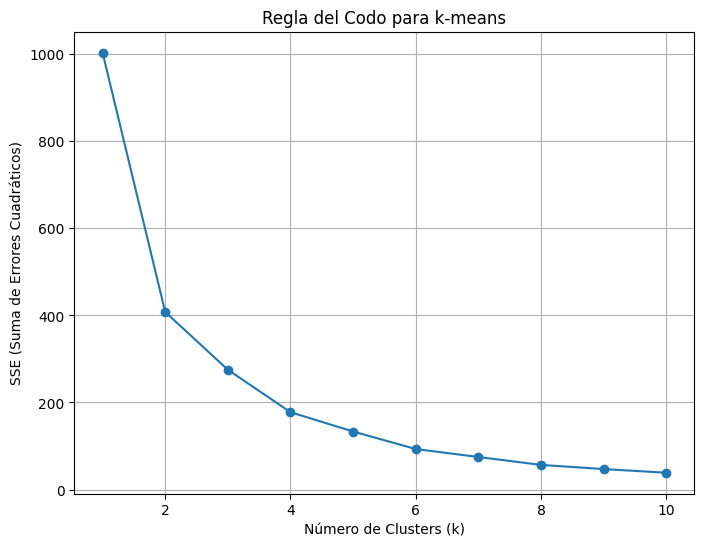

In [ ]:
sse = []
for k in range(1, 11):
    kmeans = cluster.KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# Representar gráficamente la regla del codo
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Regla del Codo para k-means')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('SSE (Suma de Errores Cuadráticos)')
plt.grid(True)
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

En el caso del dataset moon, podemos observar que no es facil la eleccion de K con el metodo del codo y no coincide con la observacion de los datos al principio del ejercicio donde se esperaban 2 cluster perfectamente diferenciados. Para poder mejorar la eleccion de K se podria utilizar otro metodo como el coeficiente de silueta o utilizar otros metodos diferentes a kmeans.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Moons.
</div>

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


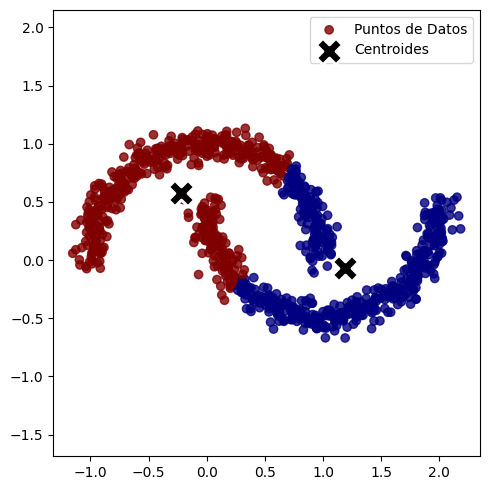

In [ ]:
# Configurar el gráfico
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Configurar y ajustar el modelo K-means
kmeans = cluster.KMeans(n_clusters=2, algorithm='full')
labels = kmeans.fit_predict(X)

# Visualizar los puntos de datos y los centroides
scatter = ax.scatter(X[:, 0], X[:, 1], c=labels, alpha=0.8, cmap='jet')
centers = ax.scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
    s=350, c='k', marker='X', linewidths=2, edgecolors='w'
)

# Añadir leyenda
ax.legend([scatter, centers], ['Puntos de Datos', 'Centroides'])

# Configurar el aspecto del gráfico
ax.axis('equal')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

En este caso, se observar que el algoritmo ha clasificado de forma erronea los datos en dos cluster. Esto se debe a la utilizacion de kmeans con la distancia euclidea ya que este clasifica los datos segun la distancia a los centroides haciendolos con forma circular. En este caso como no tienen forma circular los datos congregados se ha producido el error.


> Bloque con sangría



<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Pregunta abierta, ¿qué tendrías que cambiar para conseguir encontrar los grupos en este conjunto de datos?
</div>

Para poder encontrar los grupos de este conjunto de datos de la mejor forma se podrian utilizar metricas de distancia como manhattan o chebyshev y probarlos.

De la misma manera, existe otro algoritmo de agrupamiento llamado DBSCAN el cual se basa en la densidad de los datos.

In [ ]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de la regla del codo en el dataset Circles.
</div>

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

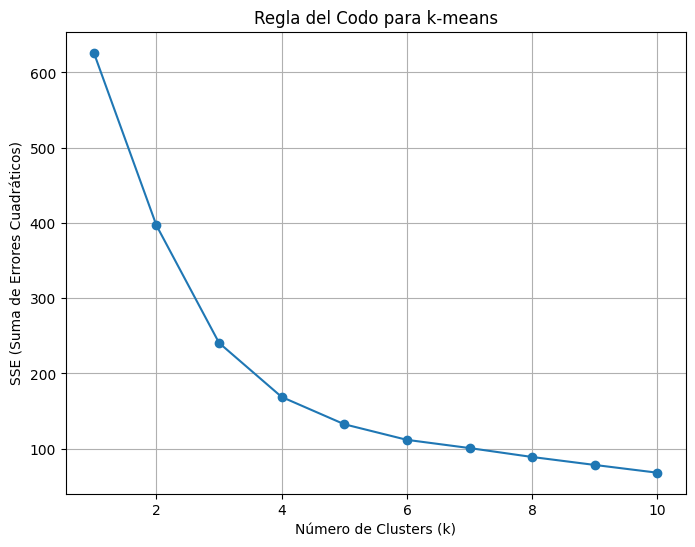

In [ ]:
sse = []
for k in range(1, 11):
    kmeans = cluster.KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    sse.append(kmeans.inertia_)

# Representar gráficamente la regla del codo
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), sse, marker='o')
plt.title('Regla del Codo para k-means')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('SSE (Suma de Errores Cuadráticos)')
plt.grid(True)
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué se interpreta en la gráfica? ¿Cómo podría mejorarse la elección de $k$?.  
</div>

En este caso ocurre como con el dataset moon, deberia de encontrar que la mejor eleccion de K serian de 2 pero en este caso no se encuentra clara la eleccion de k.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> cálculo y visualización de los grupos en el dataset Circles.
</div>

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1366: FutureWarning: algorithm='full' is deprecated, it will be removed in 1.3. Using 'lloyd' instead.
  warnings.warn(


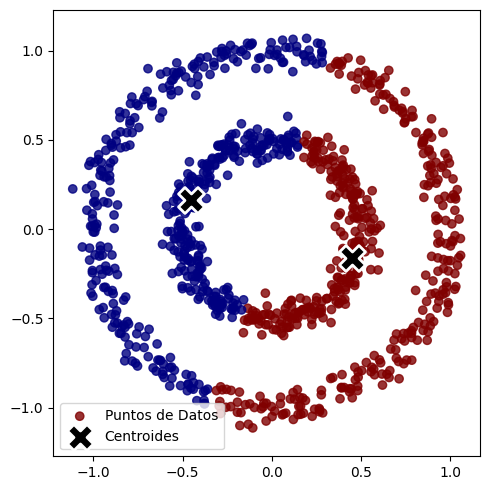

In [ ]:
# Configurar el gráfico
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

# Configurar y ajustar el modelo K-means
kmeans = cluster.KMeans(n_clusters=2, algorithm='full')
labels = kmeans.fit_predict(X)

# Visualizar los puntos de datos y los centroides
scatter = ax.scatter(X[:, 0], X[:, 1], c=labels, alpha=0.8, cmap='jet')
centers = ax.scatter(
    kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1],
    s=350, c='k', marker='X', linewidths=2, edgecolors='w'
)

# Añadir leyenda
ax.legend([scatter, centers], ['Puntos de Datos', 'Centroides'])

# Configurar el aspecto del gráfico
ax.axis('equal')
plt.tight_layout()

# Mostrar el gráfico
plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

Sucede igual que el anterior, la distancia que se utiliza no es la forma correcta para clasificar estos datos y se deberia de buscar una forma mas eficiente.

### 1 b. Algoritmos basados en densidad: DBSCAN

En este apartado se pide aplicar clustering por densidad como [DBSCAN](https://en.wikipedia.org/wiki/DBSCAN) a los datasets anteriores para detectar los dos grupos subyacentes.

Ésta es una visualización intuitiva de su funcionamiento: https://www.youtube.com/watch?v=RDZUdRSDOok

In [ ]:
X, y = X_blobs, y_blobs

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de <a href="http://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html">DBSCAN en scikit-learn</a> jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Blobs.
</div>

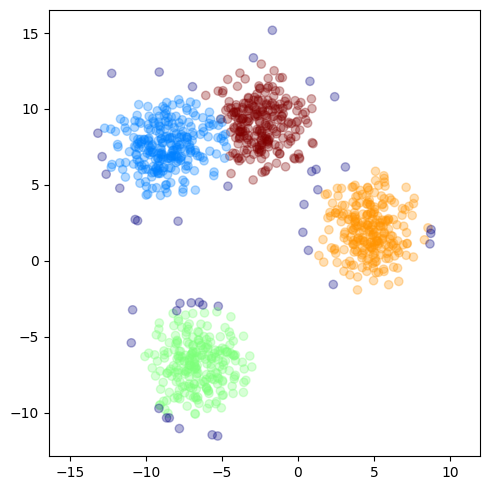

In [ ]:
mod_dbs = cluster.DBSCAN(eps=2.5, min_samples=140)
clusters = mod_dbs.fit(X)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(X[:,0], X[:,1], c=clusters.labels_, alpha=.3, cmap='jet')
ax.axis('equal')
plt.tight_layout()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

Al cambiar el algoritmo de clasificacion a DBSCAN encontramos unos parametros que podemos controlar para encontrar los cluster:

eps: este parametro es significa la disctancia maxima entre dos puntos para que sean considerados vecinos. Se utiliza para controlar la sensibilidad del algoritmo a la densidad.

min_samples: se utiliza para controlar el numero minimo de muestras en la vecindad para que se considere un punto central. Aumentar este parametro requiere que mas puntos esten cerca para formar un cluster.

En este caso se encuentran los 4 clusters utilizando eps aproximado de 2.5 y min samples aproximado de 140 con sus respectivos outliers. Esto se debe a que existe mucha densidad en sus centros (eps) y se encuentran bien separados (min_samples)

In [ ]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de DBSCAN jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Moons.
</div>

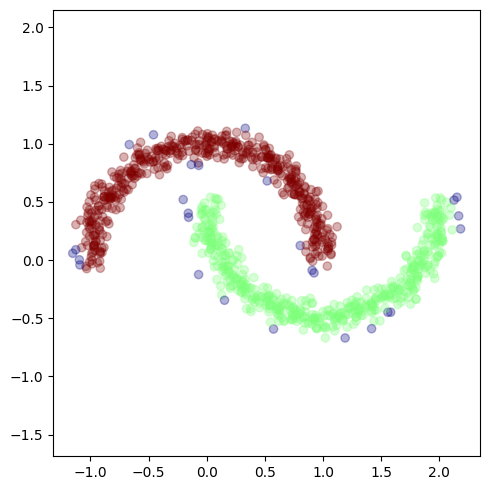

In [ ]:
model = cluster.DBSCAN(eps=0.1, min_samples=13, n_jobs=-1)
clusters = model.fit(X)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(X[:,0], X[:,1], c=clusters.labels_, alpha=.3, cmap='jet')
ax.axis('equal')
plt.tight_layout()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

En este caso se encuentran los 2 clusters utilizando eps aproximado de 0.1 y min samples aproximado de 13 con sus respectivos outliers. Esto se debe a que existe una densidad constante a lo largo de la forma que construyen y la distancia entre los dos es suficientemente grande.

In [ ]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de DBScan jugando con los parámetros <i>eps</i> y <i>min_samples</i> para encontrar los grupos (y <i>outliers</i>) del dataset Circles.
</div>

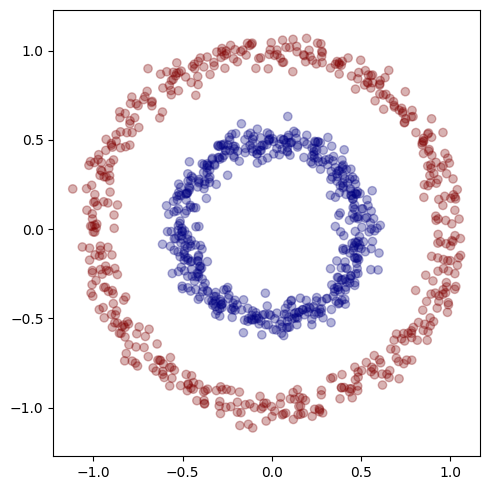

In [ ]:
model = cluster.DBSCAN(eps=0.1, min_samples=5, n_jobs=-1)
clusters = model.fit(X)

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(X[:,0], X[:,1], c=clusters.labels_, alpha=.3, cmap='jet')
ax.axis('equal')
plt.tight_layout()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> ¿Qué ha sucedido? Explica los motivos por los que crees que se ha producido ese resultado.  
</div>

En este caso se encuentran los 2 clusters utilizando eps aproximado de 0.1 y min samples aproximado de 5 con sus respectivos outliers. Esto se debe a que existe una densidad constante a lo largo de la forma que construyen y la distancia entre los dos es suficientemente grande. Pasa exactamente igual que con moon.

### 1 c. Algoritmos jerárquicos

En este apartado se pide visualizar mediante un [dendrograma](https://en.wikipedia.org/wiki/Dendrogram) la construcción progresiva de los grupos mediante un algoritmo jerárquico aglomerativo (estrategia *bottom-up*). Con ello se pretende encontrar un método gráfico para entender el comportamiento del algoritmo y encontrar los *clusters* deseados en cada dataset.

In [ ]:
X, y = X_blobs, y_blobs

<div class="alert alert-block alert-info">
<strong>Implementación:</strong> prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Blobs.<br>
Puedes importar las librerías necesarias para ello.
</div>

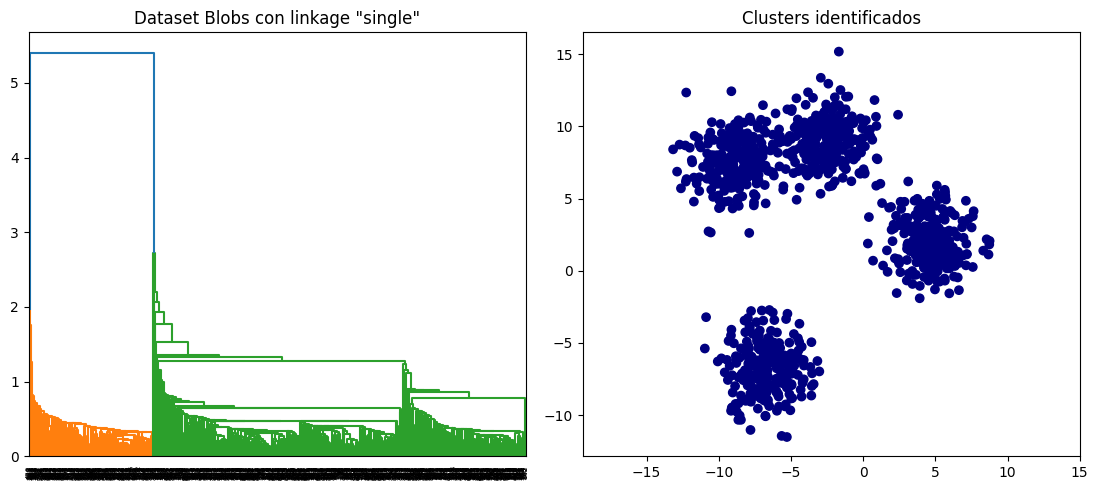

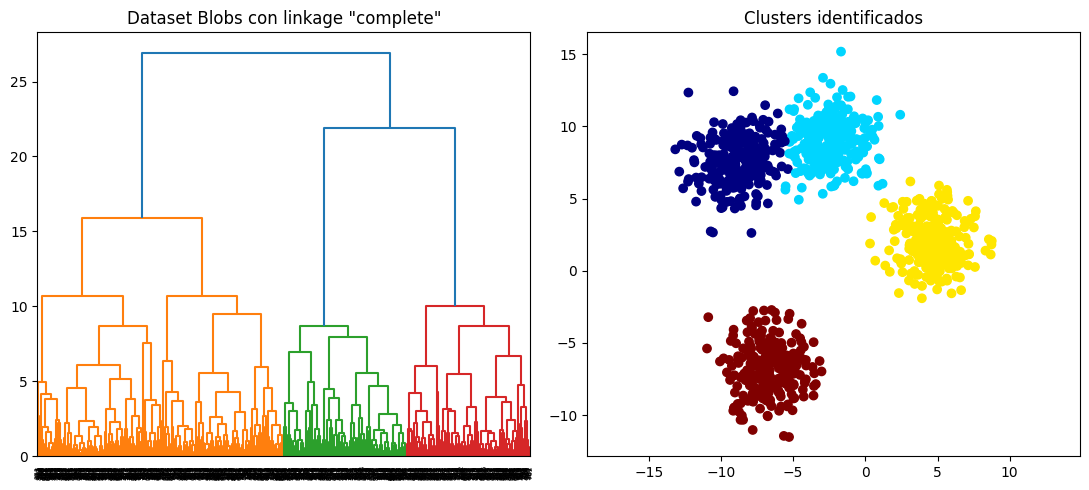

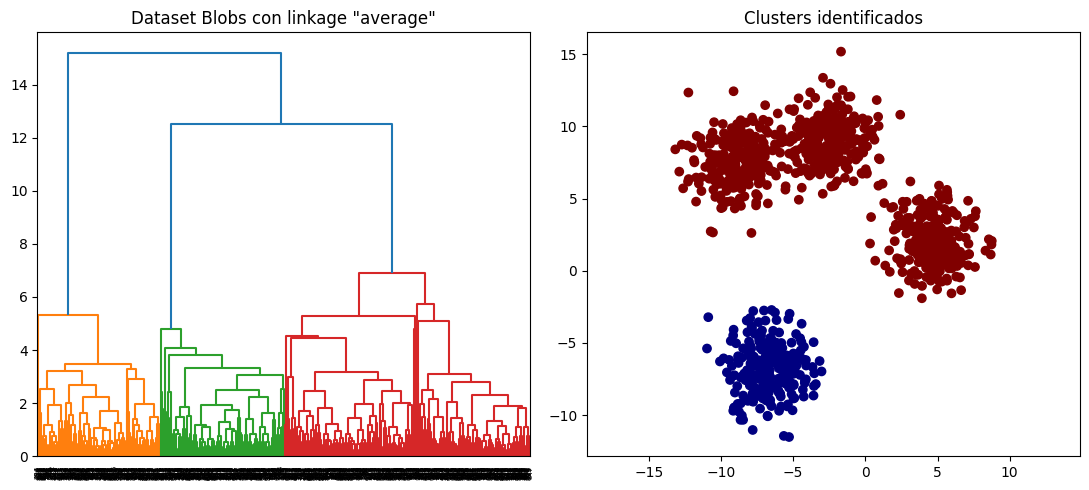

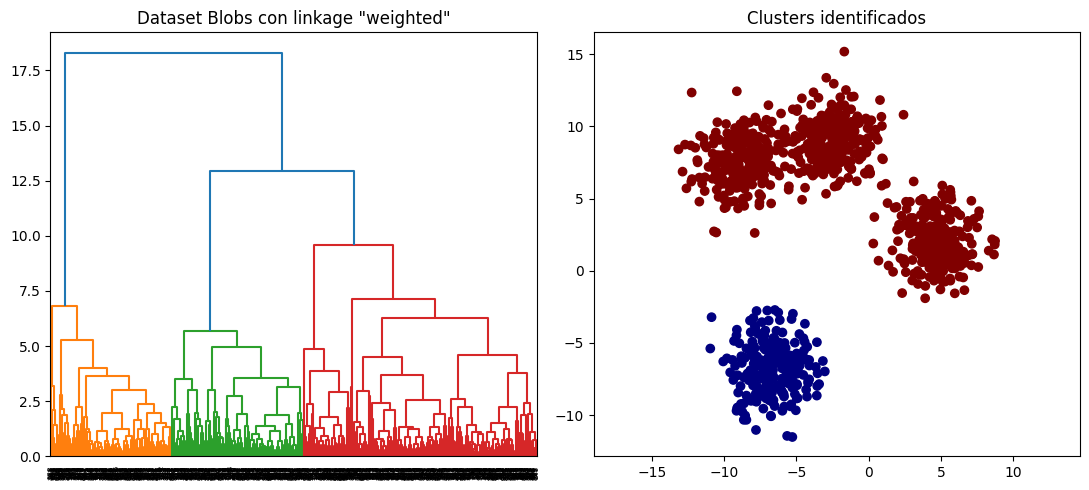

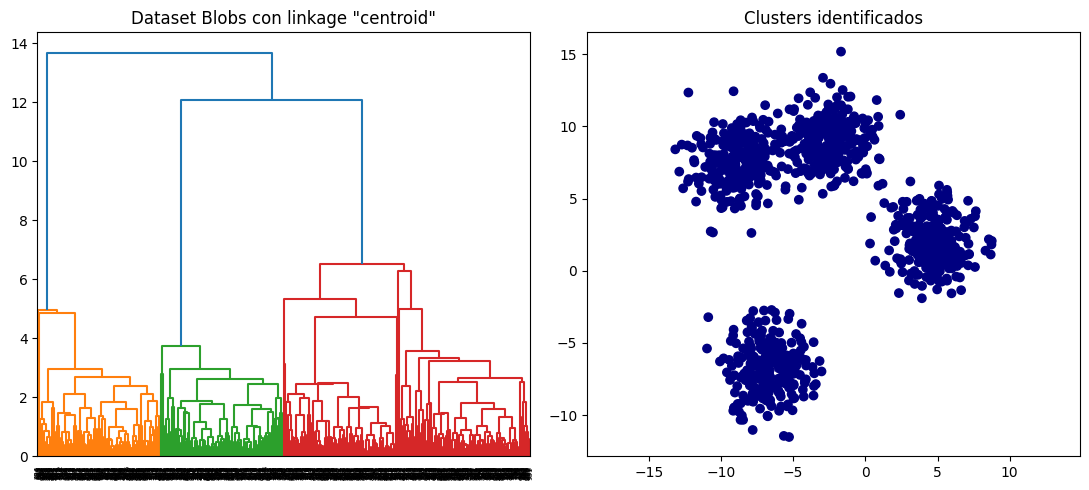

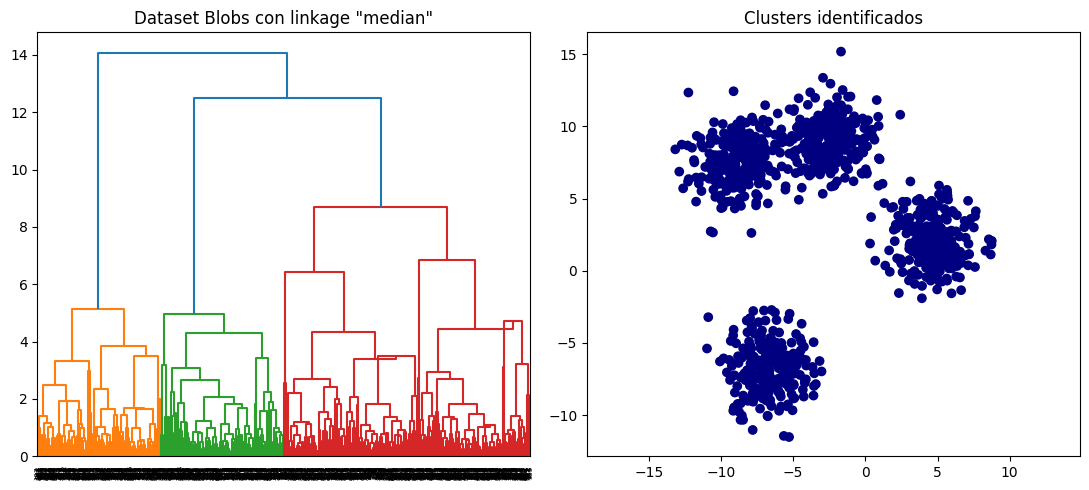

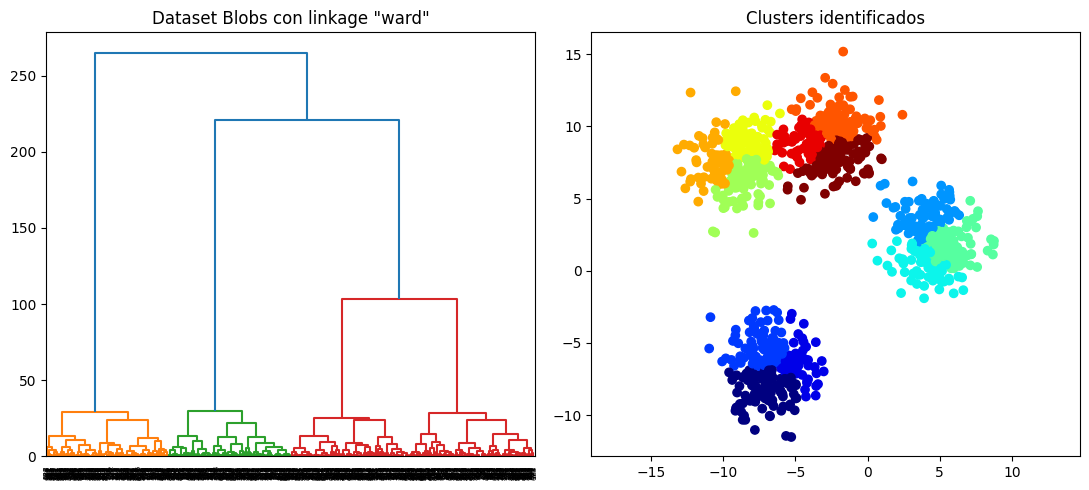

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

# Suponiendo que ya tienes X_blobs definido

# Lista de métodos de enlace a probar
linkage_methods = ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']

# Iterar sobre los métodos de enlace
for method in linkage_methods:
    # Calcular la matriz de enlace usando el método actual
    linkage_matrix = linkage(pdist(X), method=method)

    # Visualizar el dendrograma
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))
    dendrogram(linkage_matrix, ax=ax[0])
    ax[0].set_title(f'Dataset Blobs con linkage "{method}"')

    # Asignar clusters usando fcluster con el umbral de distancia especificado
    clusters = fcluster(linkage_matrix, t=15, criterion='distance')

    # Visualizar los puntos de datos coloreados por cluster
    ax[1].scatter(X[:, 0], X[:, 1], c=clusters, cmap='jet')
    ax[1].axis('equal')
    ax[1].set_title('Clusters identificados')

    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

En este casi el mejor enlace es el "complete" debido a que utiliza la maximizacion de las distancia entre los diferentes puntos del cluster, de esta manera consigue distinguir los 4 cluster desde sus centros.

In [ ]:
X, y = X_moons, y_moons

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Moons.<br>
Puedes importar las librerías necesarias para ello.
</div>

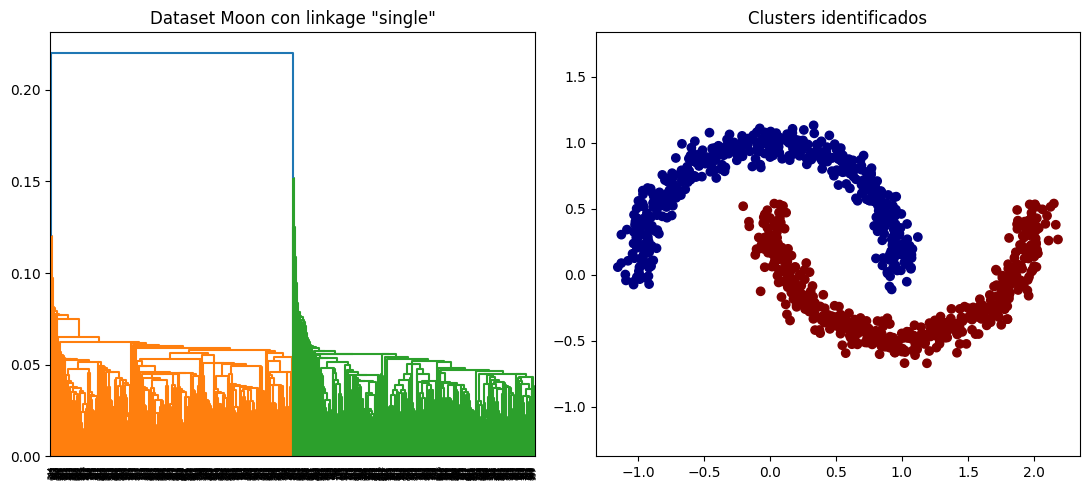

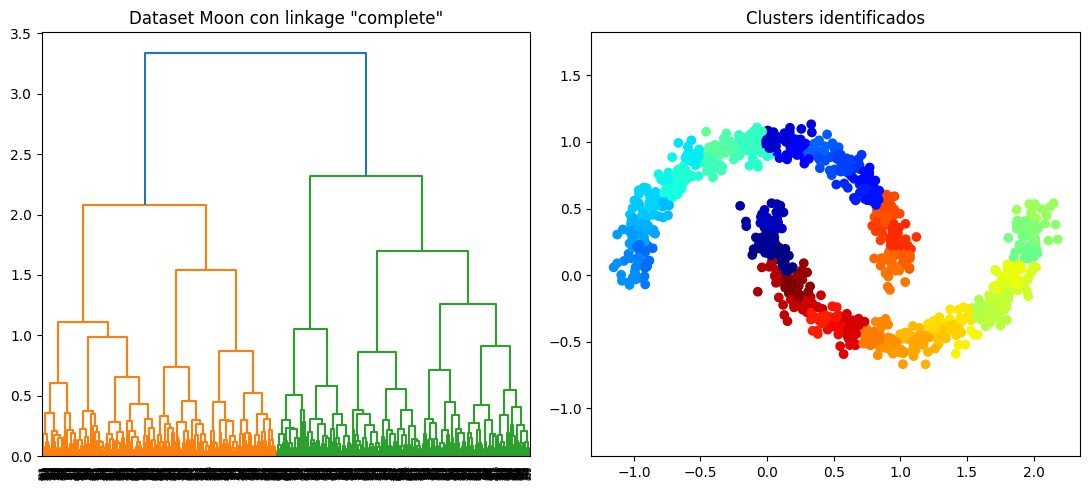

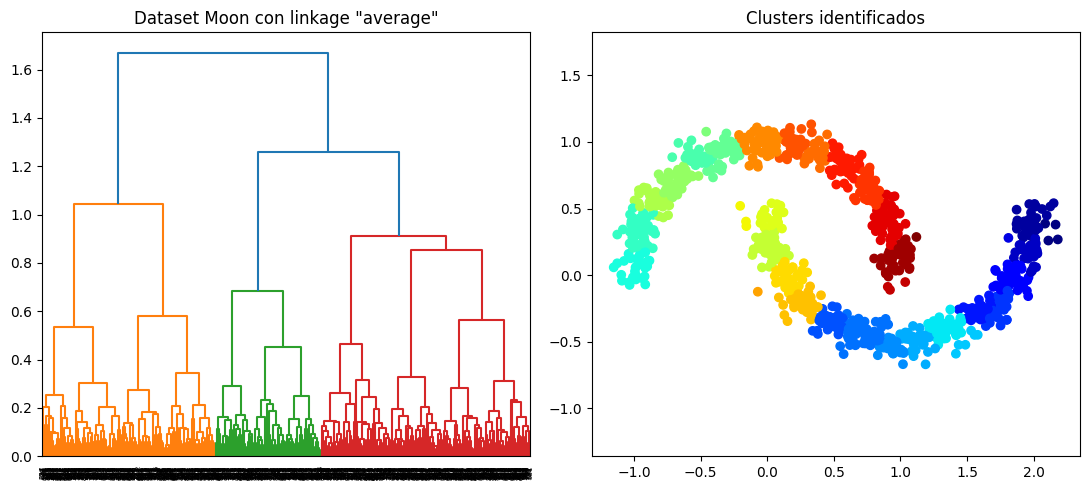

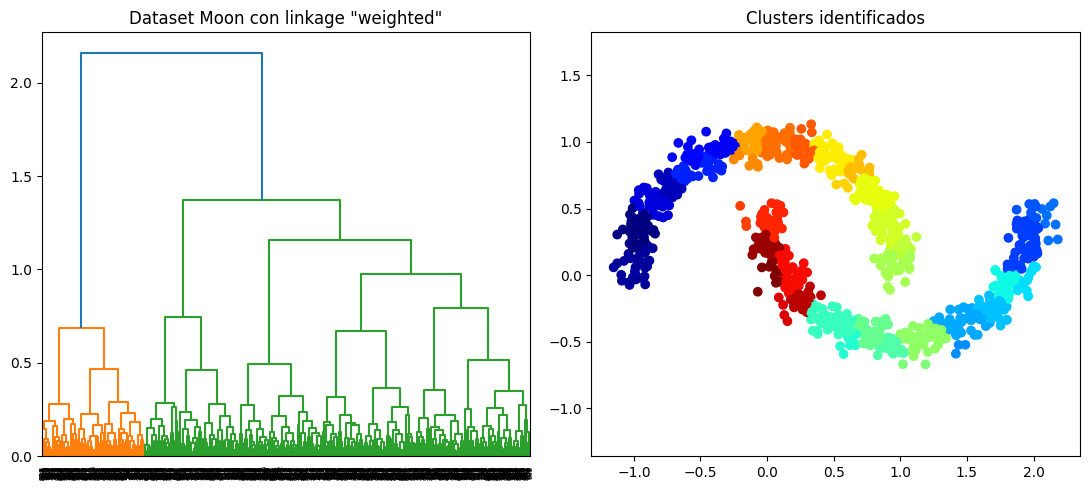

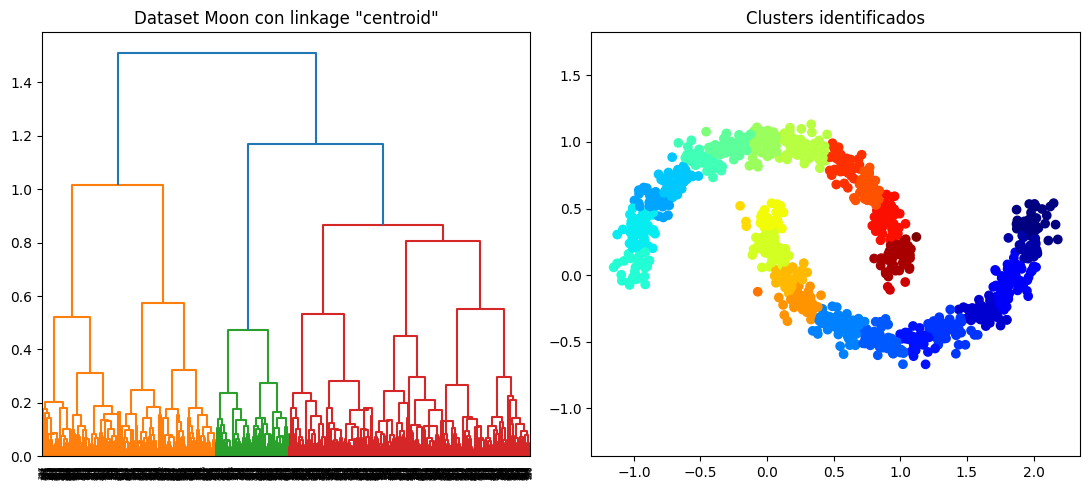

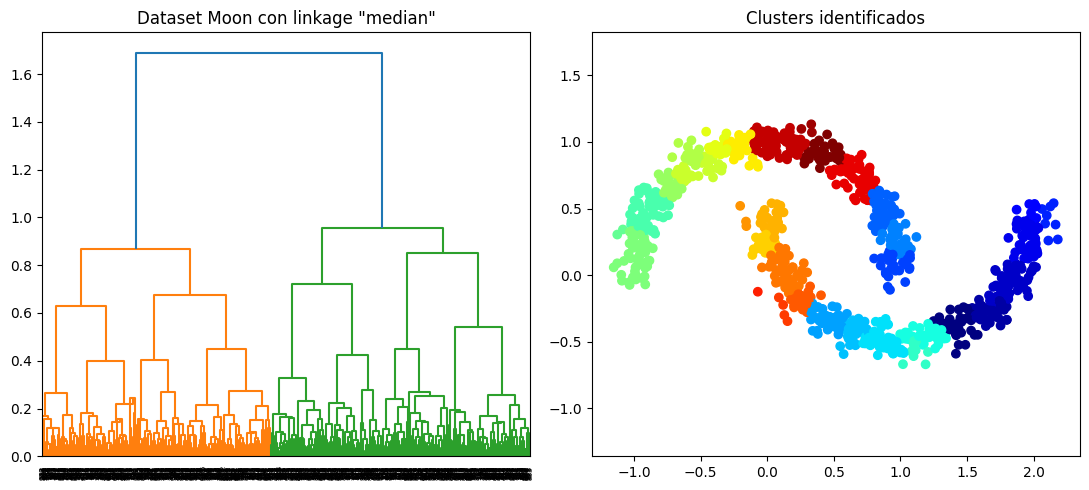

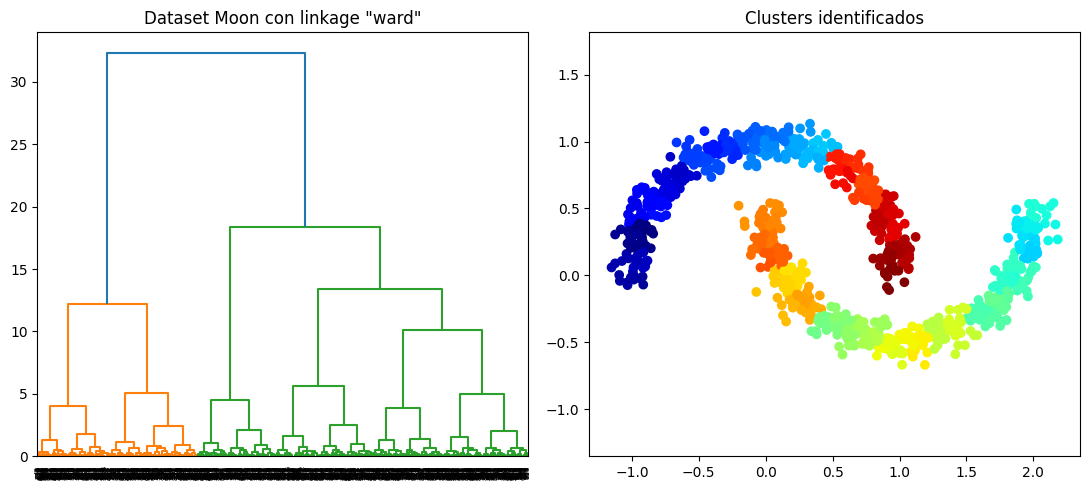

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

# Suponiendo que ya tienes X_blobs definido

# Lista de métodos de enlace a probar
linkage_methods = ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']

# Iterar sobre los métodos de enlace
for method in linkage_methods:
    # Calcular la matriz de enlace usando el método actual
    linkage_matrix = linkage(pdist(X), method=method)

    # Visualizar el dendrograma
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))
    dendrogram(linkage_matrix, ax=ax[0])
    ax[0].set_title(f'Dataset Moon con linkage "{method}"')

    # Asignar clusters usando fcluster con el umbral de distancia especificado
    clusters = fcluster(linkage_matrix, t=.2, criterion='distance')

    # Visualizar los puntos de datos coloreados por cluster
    ax[1].scatter(X[:, 0], X[:, 1], c=clusters, cmap='jet')
    ax[1].axis('equal')
    ax[1].set_title('Clusters identificados')

    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>


En este caso el enlace simple es que mejor se adapta para poder realizar la division de los dataset. Esto sucede debido a que utilizada la distancia minima entre los puntos mas proximos y encontrar los cluster que presentan formas diferentes a esferas.

In [ ]:
X, y = X_circles, y_circles

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
prueba la implementación de <a href="https://docs.scipy.org/doc/scipy/reference/cluster.hierarchy.html">clustering jerárquico de scipy</a> probando distintos <a href="https://en.wikipedia.org/wiki/Hierarchical_clustering#Linkage_criteria">criterios de enlace o <i>linkage</i></a> permitiendo identificar los clusters subyacentes (mostrando su resultado) y su dendrograma para el dataset Circles.<br>
Puedes importar las librerías necesarias para ello.
</div>

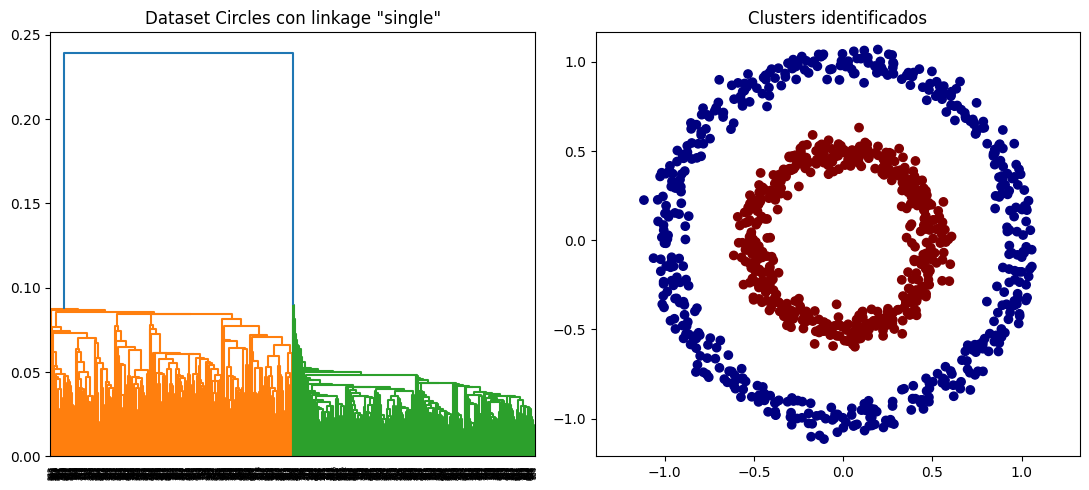

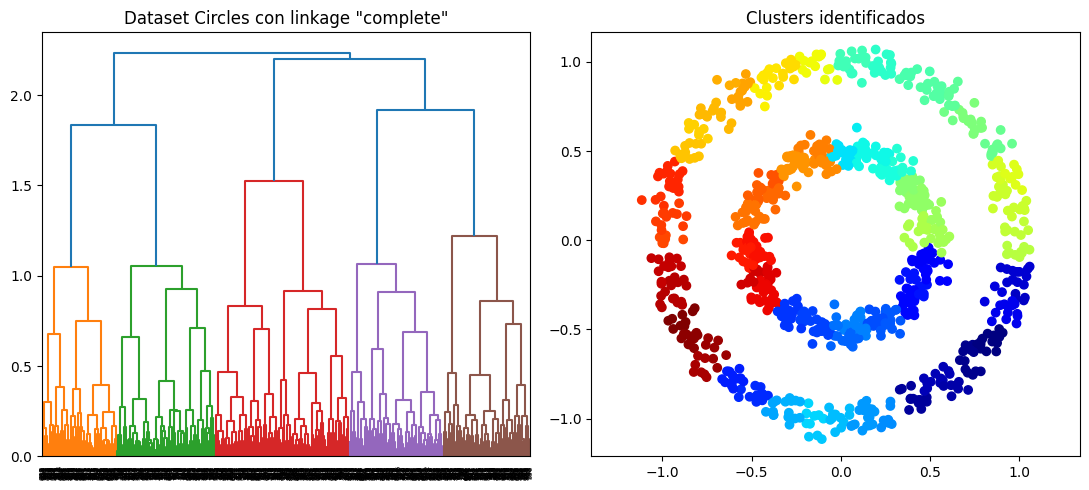

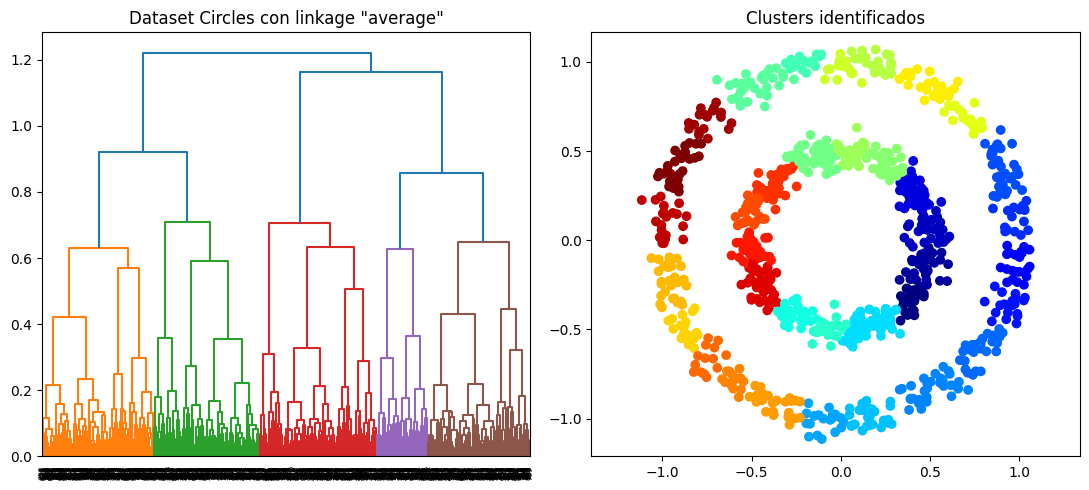

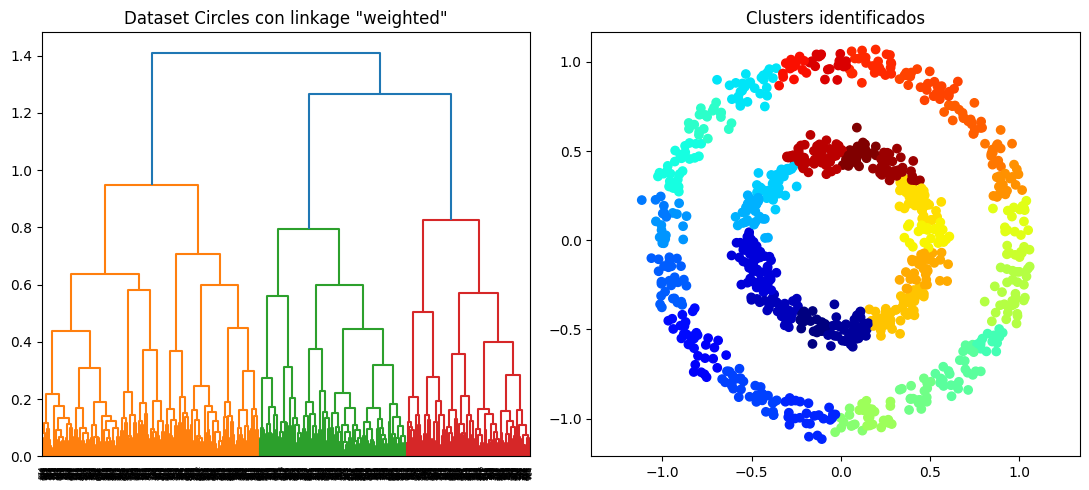

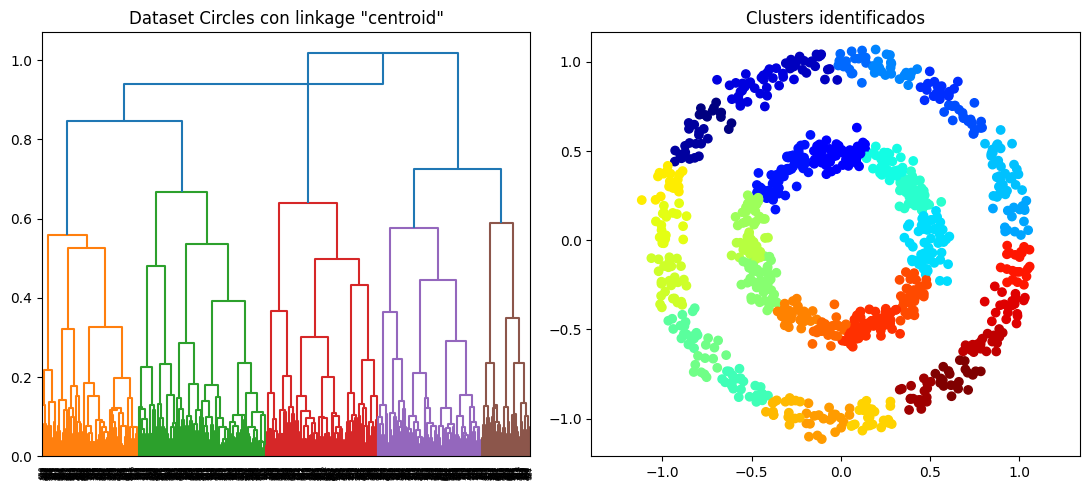

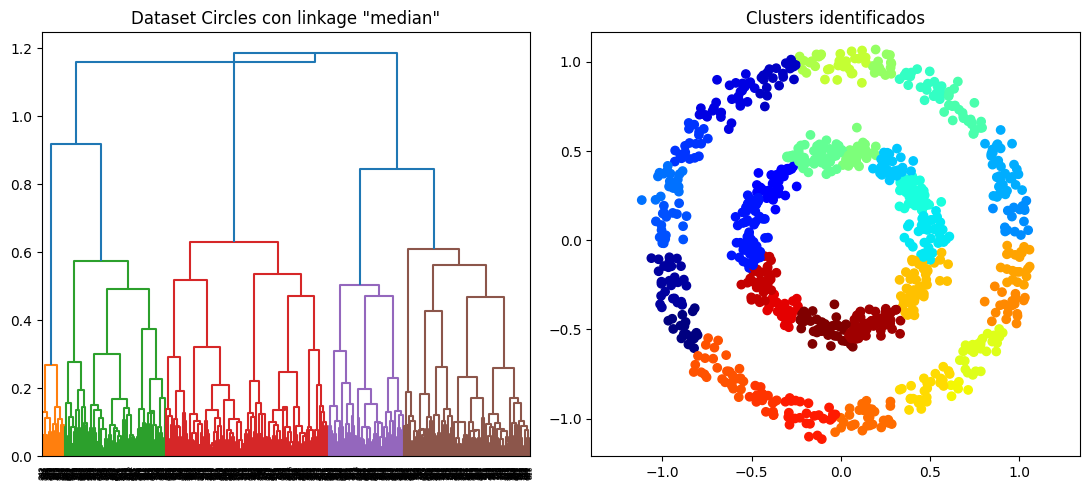

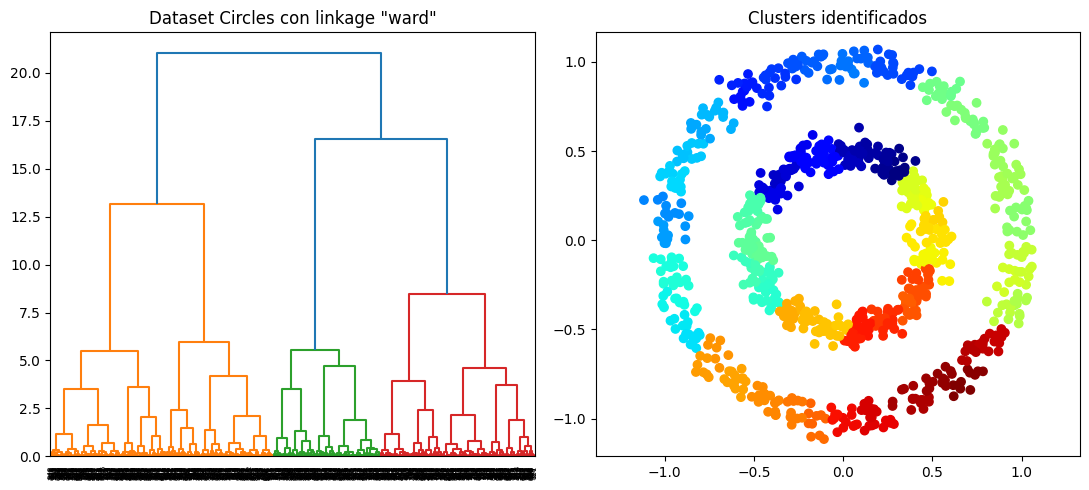

In [ ]:
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist

# Suponiendo que ya tienes X_blobs definido

# Lista de métodos de enlace a probar
linkage_methods = ['single', 'complete', 'average', 'weighted', 'centroid', 'median', 'ward']

# Iterar sobre los métodos de enlace
for method in linkage_methods:
    # Calcular la matriz de enlace usando el método actual
    linkage_matrix = linkage(pdist(X), method=method)

    # Visualizar el dendrograma
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))
    dendrogram(linkage_matrix, ax=ax[0])
    ax[0].set_title(f'Dataset Circles con linkage "{method}"')

    # Asignar clusters usando fcluster con el umbral de distancia especificado
    clusters = fcluster(linkage_matrix, t=0.2, criterion='distance')

    # Visualizar los puntos de datos coloreados por cluster
    ax[1].scatter(X[:, 0], X[:, 1], c=clusters, cmap='jet')
    ax[1].axis('equal')
    ax[1].set_title('Clusters identificados')

    plt.tight_layout()

    # Mostrar el gráfico
    plt.show()

<div class="alert alert-block alert-info">
<strong>Análisis:</strong> Interpreta el dendrograma y comenta qué criterio de enlace se ha comportado mejor. ¿Por qué?
</div>

En este caso el enlace simple es que mejor se adapta para poder realizar la division de los dataset. Esto sucede debido a que utilizada la distancia minima entre los puntos mas proximos y encontrar los cluster que presentan formas diferentes a esferas.

<a id="ej2"></a>

## 2. Ejemplo práctico con aperturas de ajedrez: reducción de dimensionalidad (6 puntos)

En ajedrez existen multitud de aperturas y variantes. Te permiten planificar como posicionarás tus piezas, lo cual puede otorgar una gran ventaja durante el desarrollo de la partida. Hay tantas aperturas distintas (cada una de ellas con sus variantes) que puede ser dificil situarte, como puede apreciarse en el siguiente video del Maestro FIDE [Luis Fernández](https://www.youtube.com/watch?v=soeEeadcOKw).

Como muchas aperturas se parecen a otras, porque tienen planes similares, una buena forma para ubicarse es saber cuales se parecen entre sí. Y esa es la idea de este análisis.

Partiremos de un [dataset de partidas de ajedrez](https://www.kaggle.com/datasets/datasnaek/chess) en la plataforma [lichess](https://lichess.org/), que consta de los siguientes campos (se resaltan los útiles para el análisis):

   - Game ID
   - Rated (T/F)
   - Start Time
   - End Time
   - **Number of Turns**
   - Game Status
   - Winner
   - Time Increment
   - White Player ID
   - White Player Rating
   - Black Player ID
   - Black Player Rating
   - **All Moves in Standard Chess Notation**
   - Opening Eco (código estandar de aperturas)
   - **Opening Name**
   - **Opening Ply** (número de movimientos de la apertura de la partida)

Se carga el dataset en un dataframe de pandas:

In [ ]:
df = pd.read_csv('games.csv')
print(df.head())

         id  rated    created_at  last_move_at  turns victory_status winner  \
0  TZJHLljE  False  1.504210e+12  1.504210e+12     13      outoftime  white   
1  l1NXvwaE   True  1.504130e+12  1.504130e+12     16         resign  black   
2  mIICvQHh   True  1.504130e+12  1.504130e+12     61           mate  white   
3  kWKvrqYL   True  1.504110e+12  1.504110e+12     61           mate  white   
4  9tXo1AUZ   True  1.504030e+12  1.504030e+12     95           mate  white   

  increment_code       white_id  white_rating      black_id  black_rating  \
0           15+2       bourgris          1500          a-00          1191   
1           5+10           a-00          1322     skinnerua          1261   
2           5+10         ischia          1496          a-00          1500   
3           20+0  daniamurashov          1439  adivanov2009          1454   
4           30+3      nik221107          1523  adivanov2009          1469   

                                               moves opening_e

### 2 a. Preparación del dato

El primer paso al tratar con dato real es analizar el dato para comprender el dominio, y aplicar determinados filtrados en base a la lógica de tu tarea.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
filtra (quédate) las partidas que tienen aperturas de 4 o más movimientos (campo opening_ply).
</div>

In [ ]:
df = df[df['opening_ply'] >= 4]

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
filtra (quédate) las partidas que tienen al menos el doble de movimientos (campo "turns") que los de la apertura (campo opening_ply).
</div>

In [ ]:
df = df[df['turns'] / 2 > df['opening_ply']]

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
si el nombre de la apertura (campo opening_name) contiene el caracter "|" ignora todo el texto que le sigue.
</div>

In [ ]:
df['opening_name'] = df['opening_name'].apply(lambda x: x.split('|')[0].strip())

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
filtra (quédate) sólo las aperturas (por su nombre, campo opening_name) que hayan sido usadas en al menos 40 partidas. Para tener un mínimo de muestras de ese tipo, eliminando muchas aperturas apenas usadas.
</div>

In [ ]:
df_new = df['opening_name'].value_counts() >= 40
df_top = set(df_new.index[df_new])
df = df[df['opening_name'].apply(lambda x: x in df_top)]

**AVISO: ¡no es necesario saber interpretar correctamente la notación algebraica para el desarrollo de la práctica!**

Los movimientos en ajedrez se pueden transcribir de distintas maneras, la más popular es la [notación algebraica](https://es.wikipedia.org/wiki/Notaci%C3%B3n_algebraica). En este caso, la notación algebraica empleada es la inglesa.

En concreto, el campo **moves** tiene los movimientos alternos tanto de las blancas como de las negras. Por tanto, la secuencia:

```e4 c5 Nf3 Qa5...```

Se interpretaría como:

 - Las blancas mueven el peón de rey a la casilla e4.
 - Las negras responden con el peón a c5.
 - Las blancas mueven el caballo (N) a la casilla f3.
 - Las negras mueven su dama a la casilla a5.

Y así alternan movimientos hasta el final de la partida (victoria, tablas, abandono o quedarse sin tiempo).

Es importante tener en cuenta que el campo **moves** es de tipo *string*, por lo que será necesario dividirlo por el separador (espacio) para tener cada movimiento por separado. Útil para los siguientes pasos.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
crea una columna llamada "white_moves" que contenga una lista con sólo los movimientos de la apertura del participante blanco (los impares del campo moves y tantos como indique opening_ply).
</div>

In [ ]:
df['white_moves'] = df.apply(
    lambda x: [m for i, m in enumerate(x.moves.split(' ')) if i % 2 == 0 and i < x.opening_ply * 2],
    axis=1)

Para comparar las aperturas entre sí usaremos los movimientos empleados en ella sólo por parte del jugador blanco (sólo hay nombre de la apertura del jugador blanco). Por simplicidad, podemos ignorar su orden, por lo que podemos usar la estrategia de [bag of words](https://es.wikipedia.org/wiki/Modelo_bolsa_de_palabras). Generando, a partir del campo **white_moves** un nuevo dataset con tantas dimensiones como posibles movimientos con un 1 si se ha realizado durante la apertura y un 0 si no se ha realizado.

Puedes crear nuevas columnas a partir de valores con el método [get_dummies()](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) de pandas.

Si el campo a partir del cual quieres generar las dimensiones es una lista de strings, [aquí](https://stackoverflow.com/questions/47786822/how-do-you-one-hot-encode-columns-with-a-list-of-strings-as-values) hay una pista.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
crea un nuevo dataframe usando el modelo bag of words a partir del campo white_moves. Puedes usar para ello el método get_dummies.
</div>

In [ ]:
data_bag = df['white_moves'].str.join('|').str.get_dummies()

### 2 b. Reducción de dimensionalidad

En este punto tienes un dataset con tantas filas como partidas y tantas columnas como movimientos posibles efectuados en el conjunto de datos.

El problema es que ahora dispones de muchas dimensiones, por lo que para visualizar los datos y comprobar si hay algún tipo de estructura es necesario reducir su dimensionalidad. Obteniendo un *embedding* (representación compacta) de las aperturas.

La reducción de dimensionalidad puede llevarse a cabo con métodos como PCA. Pero este método tiene la limitación de que sólo realiza proyecciones lineales. Por lo que otros métodos como [t-SNE](https://www.youtube.com/watch?v=NEaUSP4YerM) o [UMAP](https://www.youtube.com/watch?v=jth4kEvJ3P8) pueden ofrecer mejores resultados.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
reduce la dimensionalidad de los datos mediante UMAP a dos dimensiones para poder visualizarlo posteriormente.
</div>

In [ ]:
model = umap.UMAP()
data_map = model.fit_transform(data_bag)

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
visualiza la reducción de dimensionalidad mediante un scatter plot de la librería <strong>matplotlib</strong> donde cada punto es una muestra con coordenadas obtenidas tras la reducción de dimensionalidad para poder observar las estructuras que han emergido en el nuevo espacio.
</div>

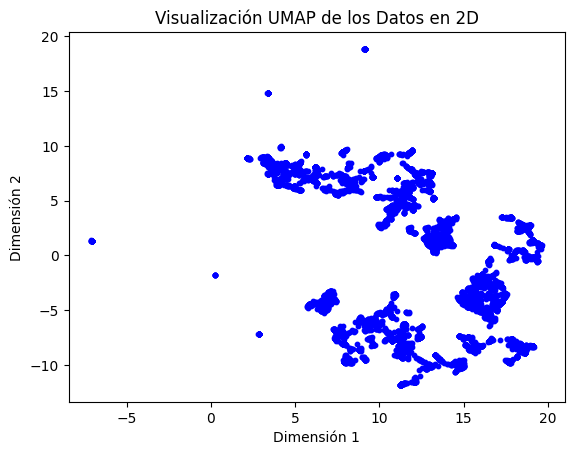

In [ ]:
import matplotlib.pyplot as plt

# Crear un scatter plot
plt.scatter(data_map[:, 0], data_map[:, 1], c='b', marker='o', s=10)

# Configurar etiquetas y título
plt.title('Visualización UMAP de los Datos en 2D')
plt.xlabel('Dimensión 1')
plt.ylabel('Dimensión 2')

# Mostrar el gráfico
plt.show()

<div class="alert alert-block alert-info">
<strong>Implementación opcional:</strong>
visualiza la reducción de dimensionalidad mediante un scatter plot de la librería <strong>plotly</strong>, al igual que antes, donde cada punto es una muestra con coordenadas obtenidas tras la reducción de dimensionalidad. De tal manera que al situarnos encima de cada muestra con el ratón (hovertext) nos indique el nombre de la apertura usada, para poder explorar mejor los datos.
</div>

In [ ]:
import plotly.graph_objects as go

fig = go.Figure(
    data=[go.Scatter(
        x=data_map[:, 0],
        y=data_map[:, 1],
        mode='markers',
        hovertext=df['opening_name'],
        marker=dict(
            color='LightSkyBlue',
            size=4,
            opacity=0.2,
        )
    )]
)


fig.update_layout(
    paper_bgcolor='white',
    plot_bgcolor='white',
)

fig.show()

### 2 c. Clustering

Tras observar la estructura de las muestras en baja dimensionalidad.

<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
¿Qué método de clustering sería adecuado para detectar los distintos grupos? ¿Por qué?
</div>

Viendo las graficas de los datos puede funcionar el algoritmo HBSCAN, ya que se bansa en la densidad de los datos. Se puede observar que los grupos mantienen diferente tamaño por lo que son irregulares y este algoritmo podria funcionar



<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
realiza el clustering con la técnica elegida para que encuentre automáticamente los grupos.
</div>

<Axes: ylabel='$\\lambda$ value'>

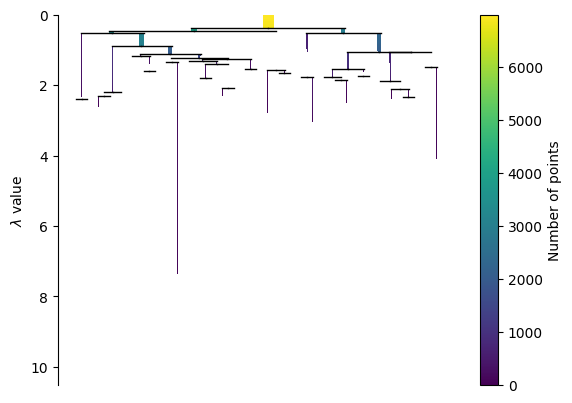

In [ ]:

import hdbscan

model = hdbscan.HDBSCAN(min_cluster_size=60)
model.fit(data_map)
model.labels_.max()

model.condensed_tree_.plot()

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
visualiza el anterior scatter plot con matplotlib (y opcionalmente con plotly) con la novedad de que el color de cada muestra se corresponda con el cluster asociado para poder observar el efecto del clustering. Utiliza una paleta de colores cualitativa (discreta) para facilitar su interpretación.
</div>

In [ ]:
fig = go.Figure(
    data=[go.Scatter(x=data_map[model.labels_ >= 0,0],
                     y=data_map[model.labels_ >= 0,1],
                     mode='markers',
                     hovertext=df['opening_name'],
                     marker=dict(
                         color=model.labels_[model.labels_ >= 0],
                         size=5,
                         opacity=0.2,
                         colorscale=px.colors.qualitative.Light24
                     ),
                    )],
    layout=dict(title="Opening's embedding",
                width=900,
                height=800,
                paper_bgcolor='rgba(0,0,0,0)',
                plot_bgcolor='rgba(0,0,0,0)',
                xaxis=dict(
                    linecolor='#cccccc',
                    linewidth=1,
                    zeroline=False,
                    visible=True
                ),
                yaxis=dict(
                    linecolor='#cccccc',
                    linewidth=1,
                    zeroline=False,
                    visible=True
                ),
               ))
fig.show()

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
para cada cluster, visualiza un gráfico de barras donde cada barra sea una de las aperturas que aparecen en el cluster y su tamaño se corresponda con el número de muestras dentro de ese grupo que han realizado esa apertura. Como consejo, puedes usar matplotlib o incluso pandas. También puede ser útil graficar con barras horizontales en lugar de verticales para facilitar su lectura.
</div>

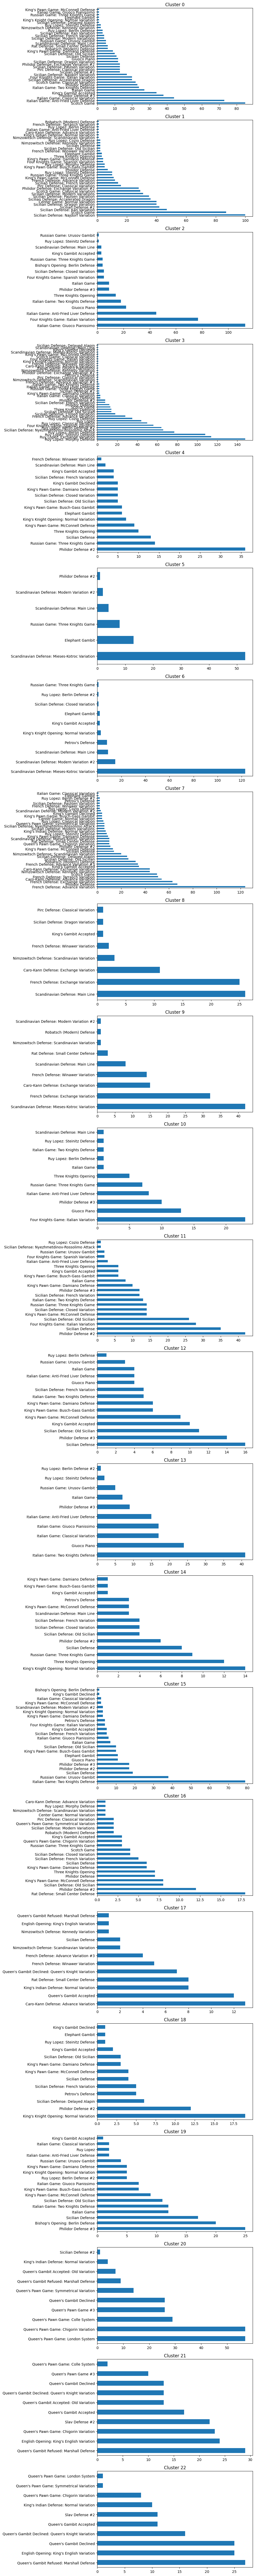

In [ ]:
fig, axis = plt.subplots(model.labels_.max() + 1, 1, figsize=(10, 100))
for ax, i in zip(axis.squeeze(), range(model.labels_.max() + 1)):
    df[model.labels_ == i]['opening_name'].value_counts().plot(kind='barh', ax=ax, title=f'Cluster {i}')
plt.tight_layout()

### 2 d. Análisis

Una manera habitual de comparar variables (en este caso aperturas) es emplear una matriz de distancias. Donde podemos representar cuál es la distancia mínima, media o máxima entre dos aperturas.

Dado que cada apertura tiene distintas muestras (al menos 40). Si usamos el mínimo y tuviésemos 5 muestras de la apertura A y 3 de la B. La distancia entre las aperturas A y B sería la mínima de las 15 distancias posibles que hay entre las 5 muestras de A y las 3 de B.

<div class="alert alert-block alert-info">
<strong>Implementación:</strong>
calcula y visualiza la distancia (euclídea en este caso) entre todas las aperturas mediante una matriz de distancias usando plotly o seaborn (mediante un heatmap). El proceso de cálculo puede llevar mucho tiempo. Se recomienda calcular la distancia entre las muestras en baja dimensionalidad usando la librería numpy empleando la normal tras la resta de las muestras. Si aún así se dilata en el tiempo puedes probar a realizar sampling aleatorio del dataset para reducir el número de muestras. Peinsa que la matriz de distancia tiene bastantes simetrías que pueden ser aprovechadas para ahorrar cálculos. Puedes utilizar tqdm para visualizar y estimar la duración del proceso de cálculo.
</div>

In [ ]:
rnd = 0

op2idx = {op : i for i, op in enumerate(df['opening_name'].value_counts().index)}
dists = np.full((len(op2idx), len(op2idx)), 99999.)
for i, (_, op_a) in tqdm.tqdm(enumerate(df['opening_name'].iteritems()), total=df.shape[0]):
    for j, (_, op_b) in enumerate(df['opening_name'].iteritems()):
        idx_i = op2idx[op_a]
        idx_j = op2idx[op_b]
        if idx_i == idx_j:
            dists[idx_i, idx_j] = 0.
        elif dists[idx_i, idx_j] > 99998. or rnd == 0:
            #else:
            d = min(dists[idx_j, idx_i], min(dists[idx_i, idx_j], np.linalg.norm(data_map[i] - data_map[j])))
            dists[idx_i, idx_j] = d
            dists[idx_j, idx_i] = d

        rnd = (rnd + 1) % 4

fig = px.imshow(dists, color_continuous_scale='RdBu',
                x=sorted(op2idx, key=op2idx.get, reverse=False),
                y=sorted(op2idx, key=op2idx.get, reverse=False),
                width=1900, height=1900)
fig.show()

<ipython-input-23-835beed74376>:5: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

  0%|          | 0/6975 [00:00<?, ?it/s]<ipython-input-23-835beed74376>:6: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

100%|██████████| 6975/6975 [03:16<00:00, 35.56it/s]


<div class="alert alert-block alert-info">
<strong>Análisis:</strong>
Argumenta las conclusiones obtenidas tras interpretar las visualizaciones de los puntos anteriores: estructura de las muestras en baja dimensionalidad, clustering, gráficos de la dominancia de las aperturas contenidas en cada cluster y la matriz de distancias.
</div>


Después de llevar a cabo el análisis de clustering mediante HDBSCAN y la generación de una matriz de distancias entre clusters, podemos extraer las siguientes conclusiones:

Estructura en Baja Dimensionalidad:
La representación visual a través de UMAP revela patrones en nuestros datos. La agrupación en diferentes conjuntos puede indicar diferencias en las características de las muestras, sugiriendo que la reducción de dimensionalidad ha capturado eficientemente la esencia de los datos.

Clustering con HDBSCAN:
La implementación de HDBSCAN parece haber sido exitosa al lidiar con la complejidad estructural de nuestros datos, generando grupos bien definidos que destacan las similitudes entre las muestras.

Heatmap:
El heatmap exhibe la variabilidad en la proximidad entre clusters. Las disparidades en la intensidad de los colores señalan que la proximidad entre clusters no es uniforme, indicando una estructura de datos rica y posiblemente compleja. Algunos clusters muestran una mayor afinidad entre sí, sugiriendo la existencia de aperturas o estilos de juego específicos.


### 2 e. OPCIONAL

Para comprender mejor lo analizado, puedes visualizar las aperturas de las muestras mediante la librería **chess** que facilita mucho la tarea.

Para ello selecciona una muestra (más fácil) o un tipo de apertura, y de la columna *moves* selecciona 2 * *opening_ply* movimientos de la apertura (el x2 es para coger los de las blancas y las negras). Una vez que ya los tengas puedes crear un tablero con la librería chess:

```board = chess.Board()```

Tras ello, simplemente itera por esos primeros y pásaselos al tablero mediante el método ```push_san``` con:

```board.push_san('d4')```

hasta agotar los movimientos **SOLO de la apertura** de blancas y negras en el mismo orden en el que ya aparecen en el campo *moves*.

In [ ]:
!pip install chess

In [ ]:
import chess

def movimientos(df: pd.DataFrame, name: str) -> chess.Board():
    aux = df[df['opening_name'] == name].sample()
    board = chess.Board()
    print(name)
    for x in aux['moves'].values[0].split(' ')[:aux['opening_ply'].values[0] * 2]:
        board.push_san(x)
    return board

Queen's Pawn Game: Colle System


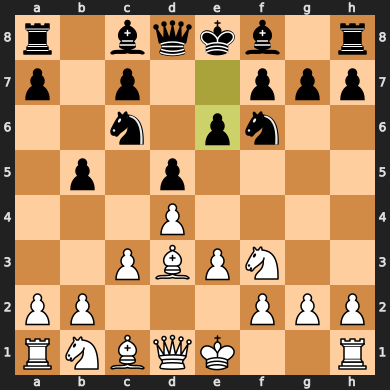

In [ ]:
movimientos(df, "Queen's Pawn Game: Colle System")